# Recurrent Neural Network (RNN) 

## Initialization

### Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow / Keras Layers
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Label preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score

2025-05-30 15:11:55.821928: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 15:11:55.825212: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 15:11:55.833275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748592715.846795  104063 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748592715.850605  104063 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748592715.861825  104063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Import Data

In [2]:
df_train = pd.read_csv('../dataset/train.csv', sep=',')
df_val = pd.read_csv('../dataset/valid.csv', sep=',')
df_test = pd.read_csv('../dataset/test.csv', sep=',')

In [3]:
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

for df in [df_train, df_val, df_test]:
    df['label_id'] = df['label'].map(label_mapping)

    if df['label_id'].isnull().any():
        print("Warning: Some labels were not mapped! Check unique labels and label_mapping.")
        print(df[df['label_id'].isnull()])

x_train = np.array(df_train['text'])
y_train = np.array(df_train['label_id'])

x_val = np.array(df_val['text'])
y_val = np.array(df_val['label_id'])

x_test = np.array(df_test['text'])
y_test = np.array(df_test['label_id'])

In [4]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (500,), y_train shape: (500,)
x_val shape: (100,), y_val shape: (100,)
x_test shape: (400,), y_test shape: (400,)


### Preprocessing Result

(Actual preprocessing can be seen in tubes2_lstm.ipynb)
Since the number of unique tokens is not significantly large, we will use (2836+1) **2837 as the vocabulary size** (max_tokens) and take the 95th percentile value of **54 as the output_sequence_length**

In [5]:
MAX_TOKENS = 2837
OUTPUT_SEQUENCE_LENGTH = 54
EMBEDDING_DIM = 64
NUM_CLASSES = 3

MODEL_SAVE_DIR = '../bin/rnn_models'
PLOT_SAVE_DIR = '../bin/rnn_plots'

In [6]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

In [7]:
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH
)

text_vectorization_layer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

2025-05-30 15:11:57.679822: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-30 15:11:59.204825: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training and Prediction

### Boilerplate Functions

In [8]:
def calculate_macro_f1(y_true, y_pred_classes):
    return f1_score(y_true, y_pred_classes, average='macro')

def plot_training_history(history, title, filename):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_SAVE_DIR, filename))
    plt.show()
    plt.close()

In [9]:
def build_rnn_model(num_rnn_layers=1, rnn_units=64, rnn_direction='unidirectional', num_classes=NUM_CLASSES):
    model = models.Sequential()

    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(text_vectorization_layer)
    model.add(layers.Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero = True
    ))

    for i in range(num_rnn_layers):
        return_sequences = (i < num_rnn_layers - 1)

        if rnn_direction == 'unidirectional':
            model.add(layers.SimpleRNN(rnn_units,return_sequences=return_sequences))
        elif rnn_direction == 'bidirectional':
            model.add(layers.Bidirectional(layers.SimpleRNN(rnn_units,return_sequences=return_sequences)))
        else:
            raise ValueError("rnn_direction must be 'unidirectional' or 'bidirectional'")
        model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [10]:
def train_and_evaluate_model(model_name, model_params, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    print(f"\n--- Training Model: {model_name} ---")
    model = build_rnn_model(**model_params)
    model.summary()

    # Define callbacks
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure directory exists
    model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best.h5') # Use .h5 for full model

    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=model_filepath,
        save_weights_only=False,  # MUST BE False to create 'model_weights' group
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )
    early_stopping_callback = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=False, # CHANGED: Set to False
        verbose=0
    )

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    plot_title = f"{model_name}"
    # You'll need to ensure plot_filename includes a valid path or that MODEL_SAVE_DIR is appropriate
    plot_filename_path = f"{model_name}_loss_accuracy.png"
    plot_training_history(history, plot_title, plot_filename_path)

    print(f"Best Keras model (full) saved to: {model_filepath}") # This file is ready for your Sequential class

    # These predictions will be based on the model state at the end of fit()
    y_val_pred_probs = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)

    y_test_pred_probs = model.predict(x_test)
    y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

    return history, y_val_pred_classes, y_test_pred_classes

In [11]:
def evaluate_macro_f1(y_true, y_pred, dataset_name="Validation"):
    """
    Calculates and prints the macro F1-score.
    """
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score on {dataset_name} set: {macro_f1:.4f}")
    return macro_f1

### Variation in Number of RNN Layers


--- Training Model: RNN_layers_1 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,019 (742.26 KB)

 Trainable params: 190,019 (742.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3650 - loss: 1.0923

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3729 - loss: 1.0774 - val_accuracy: 0.4500 - val_loss: 0.9819
Epoch 2/15
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7255 - loss: 0.8217 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7386 - loss: 0.8031 - val_accuracy: 0.5400 - val_loss: 0.9368
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9415 - loss: 0.5194 - val_accuracy: 0.5100 - val_loss: 0.9811
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9734 - loss: 0.2330 - val_accuracy: 0.4400 - val_loss: 1.1184
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9822 - loss: 0.1078 - val_accuracy: 0.4900 - val_loss: 1.1783
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0504 - val_accuracy: 0.4700 - val_loss: 1.3227
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0261 - val_accuracy: 0.4700 - val_loss: 1.3679


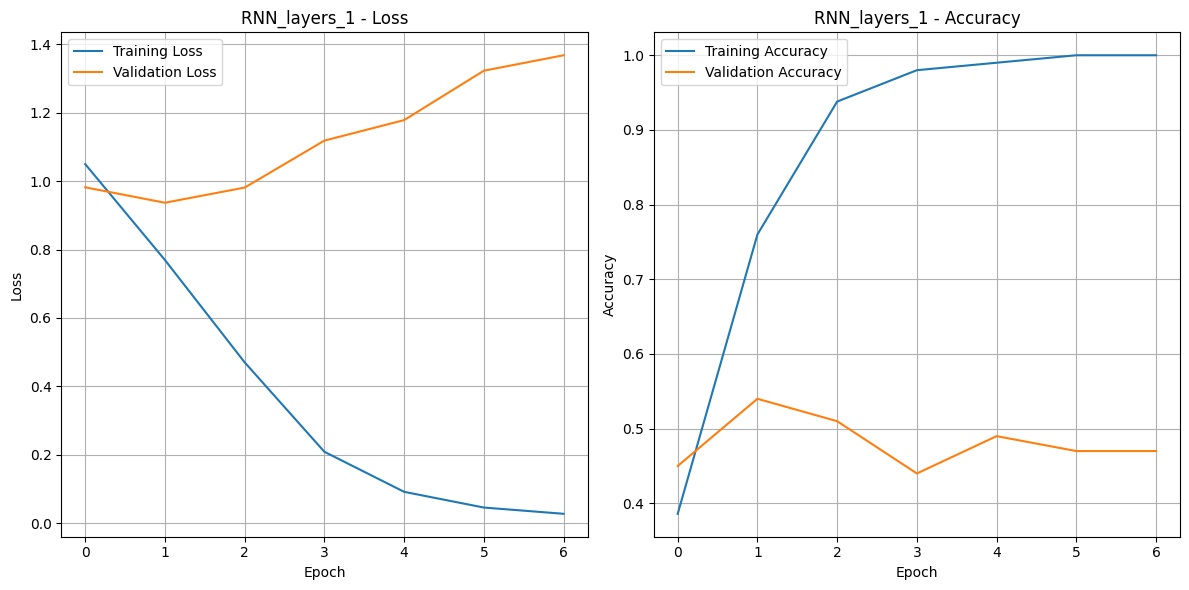

Best Keras model (full) saved to: ../bin/rnn_models/RNN_layers_1_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Macro F1-score on Validation set: 0.4314
Macro F1-score on Test set: 0.5119

--- Training Model: RNN_layers_2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,275 (774.51 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3989 - loss: 1.0997

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4008 - loss: 1.0983 - val_accuracy: 0.4700 - val_loss: 0.9978
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6749 - loss: 0.7802

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6760 - loss: 0.7784 - val_accuracy: 0.4800 - val_loss: 0.9545
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8936 - loss: 0.4210 - val_accuracy: 0.5100 - val_loss: 1.0125
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9879 - loss: 0.1468 - val_accuracy: 0.5400 - val_loss: 1.1166
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9984 - loss: 0.0481 - val_accuracy: 0.5800 - val_loss: 1.2674
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0268 - val_accuracy: 0.5700 - val_loss: 1.3051
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.5600 - val_loss: 1.4277


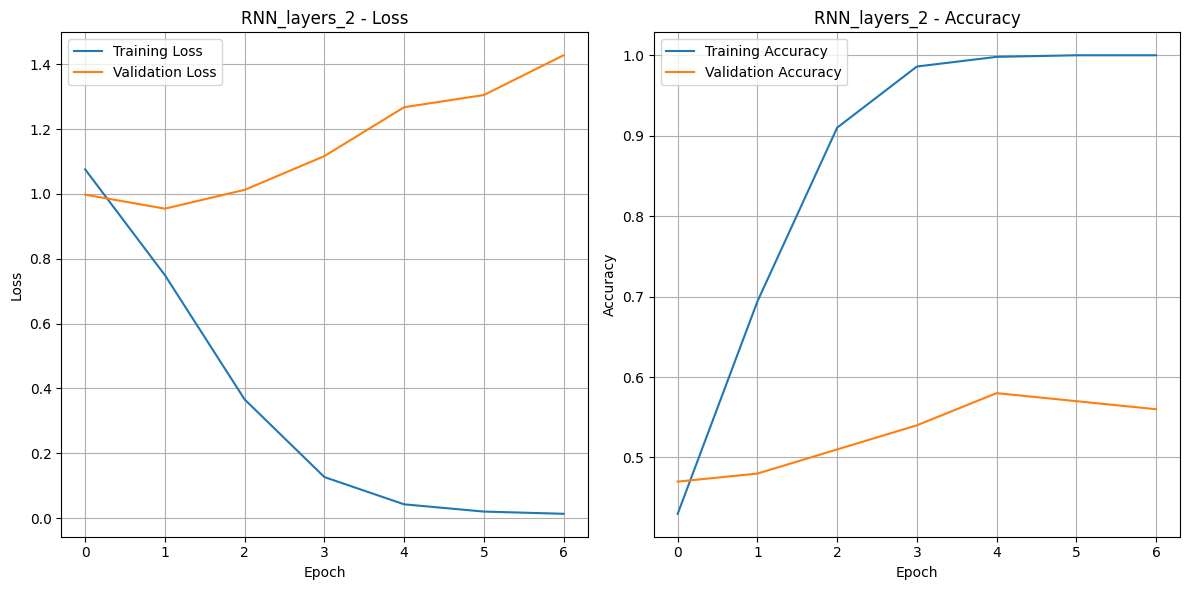

Best Keras model (full) saved to: ../bin/rnn_models/RNN_layers_2_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Macro F1-score on Validation set: 0.5542
Macro F1-score on Test set: 0.5281

--- Training Model: RNN_layers_3 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,531 (806.76 KB)

 Trainable params: 206,531 (806.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3488 - loss: 1.2564

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3586 - loss: 1.2462 - val_accuracy: 0.5200 - val_loss: 1.0250
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6610 - loss: 0.8050 - val_accuracy: 0.5100 - val_loss: 1.1781
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8057 - loss: 0.5090 - val_accuracy: 0.5000 - val_loss: 1.2446
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9402 - loss: 0.2083 - val_accuracy: 0.5200 - val_loss: 1.4484
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9839 - loss: 0.1079 - val_accuracy: 0.5800 - val_loss: 1.5687
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9919 - loss: 0.0433 - val_accuracy: 0.5800 - val_loss: 1.7302


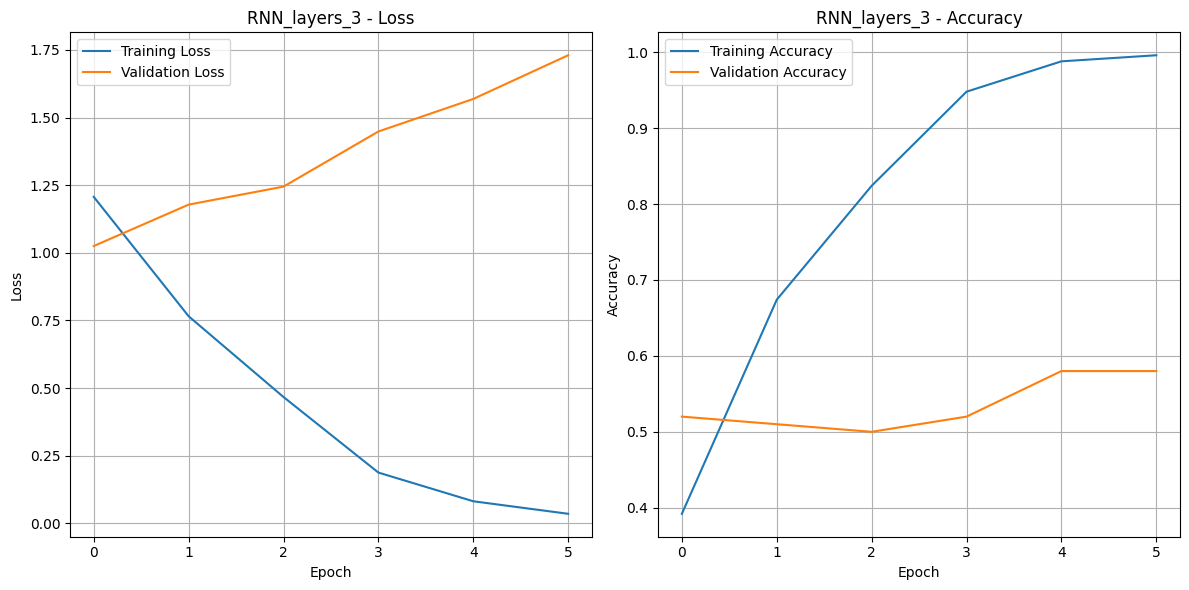

Best Keras model (full) saved to: ../bin/rnn_models/RNN_layers_3_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Macro F1-score on Validation set: 0.5422
Macro F1-score on Test set: 0.5314

--- Summary: Pengaruh jumlah layer RNN ---
RNN_layers_1: Validation Macro F1 = 0.4314, Test Macro F1 = 0.5119
RNN_layers_2: Validation Macro F1 = 0.5542, Test Macro F1 = 0.5281
RNN_layers_3: Validation Macro F1 = 0.5422, Test Macro F1 = 0.5314


In [12]:
rnn_layer_variations = [1,2,3]

results_layer_count = {}

for num_layers in rnn_layer_variations:
    model_params = {
        'num_rnn_layers' : num_layers,
        'rnn_units' : 64,
        'rnn_direction' : 'unidirectional'
    }
    model_name = f"RNN_layers_{num_layers}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_layer_count[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jumlah layer RNN ---")
for name, res in results_layer_count.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")


### Variation in Number of RNN Cells


--- Training Model: RNN_Units_32 ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 54, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,851 (729.89 KB)

 Trainable params: 186,851 (729.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3189 - loss: 1.1548

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3250 - loss: 1.1577 - val_accuracy: 0.4900 - val_loss: 1.0742
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5773 - loss: 0.8777

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5802 - loss: 0.8759 - val_accuracy: 0.4600 - val_loss: 1.0248
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8402 - loss: 0.5931 - val_accuracy: 0.4000 - val_loss: 1.1207
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9685 - loss: 0.3037 - val_accuracy: 0.4500 - val_loss: 1.2913
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9975 - loss: 0.1438 - val_accuracy: 0.4600 - val_loss: 1.3493
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0814 - val_accuracy: 0.4400 - val_loss: 1.5172
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0469 - val_accuracy: 0.4300 - val_loss: 1.6164


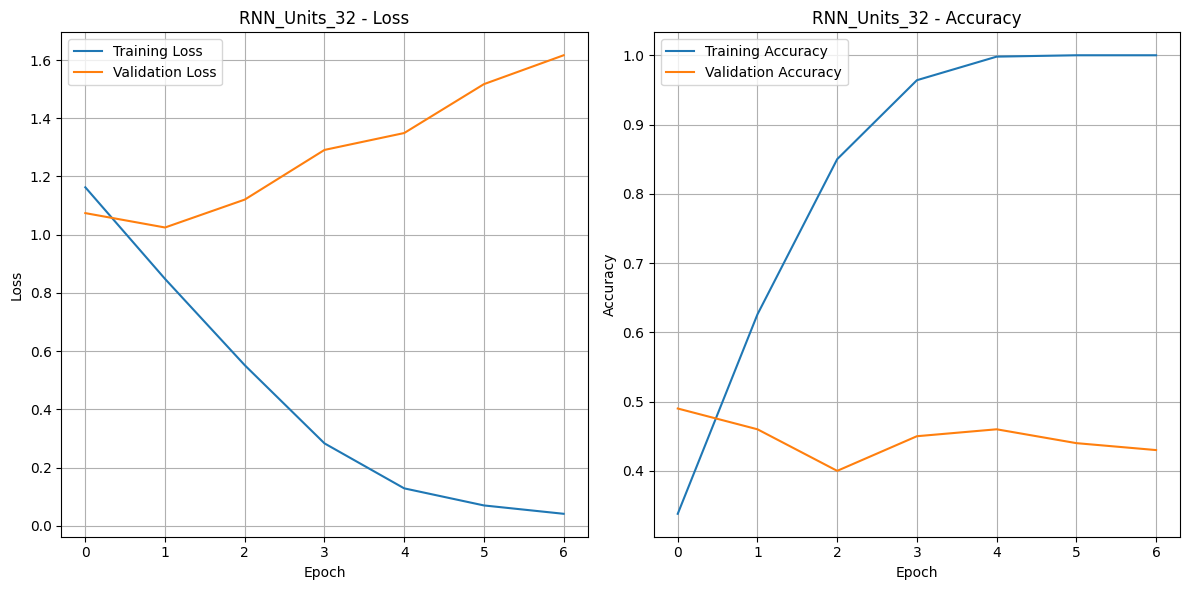

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Units_32_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Macro F1-score on Validation set: 0.4312
Macro F1-score on Test set: 0.4906

--- Training Model: RNN_Units_64 ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,275 (774.51 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3727 - loss: 1.1450

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3740 - loss: 1.1443 - val_accuracy: 0.4200 - val_loss: 1.1214
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7184 - loss: 0.7779

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7198 - loss: 0.7755 - val_accuracy: 0.4500 - val_loss: 1.1002
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9041 - loss: 0.4030 - val_accuracy: 0.5000 - val_loss: 1.1913
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9853 - loss: 0.1392 - val_accuracy: 0.5500 - val_loss: 1.2623
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9937 - loss: 0.0589 - val_accuracy: 0.5100 - val_loss: 1.3756
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 0.5300 - val_loss: 1.3913
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9970 - loss: 0.0148 - val_accuracy: 0.5200 - val_loss: 1.4312


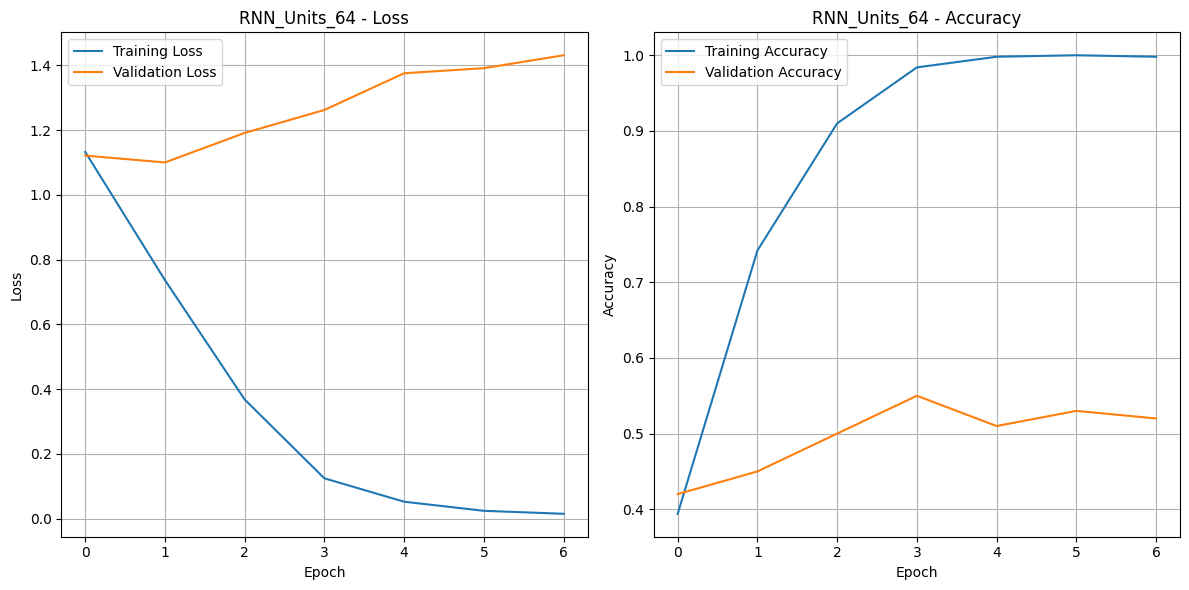

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Units_64_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Macro F1-score on Validation set: 0.4981
Macro F1-score on Test set: 0.4759

--- Training Model: RNN_Units_128 ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,555 (935.76 KB)

 Trainable params: 239,555 (935.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3771 - loss: 1.0907

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3859 - loss: 1.0904 - val_accuracy: 0.5200 - val_loss: 0.9979
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7802 - loss: 0.6751 - val_accuracy: 0.5000 - val_loss: 1.1066
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9095 - loss: 0.3311 - val_accuracy: 0.5100 - val_loss: 1.2620
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9822 - loss: 0.1037 - val_accuracy: 0.5500 - val_loss: 1.3754
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9875 - loss: 0.0458 - val_accuracy: 0.5100 - val_loss: 1.5781
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9926 - loss: 0.0395 - val_accuracy: 0.5400 - val_loss: 1.9120


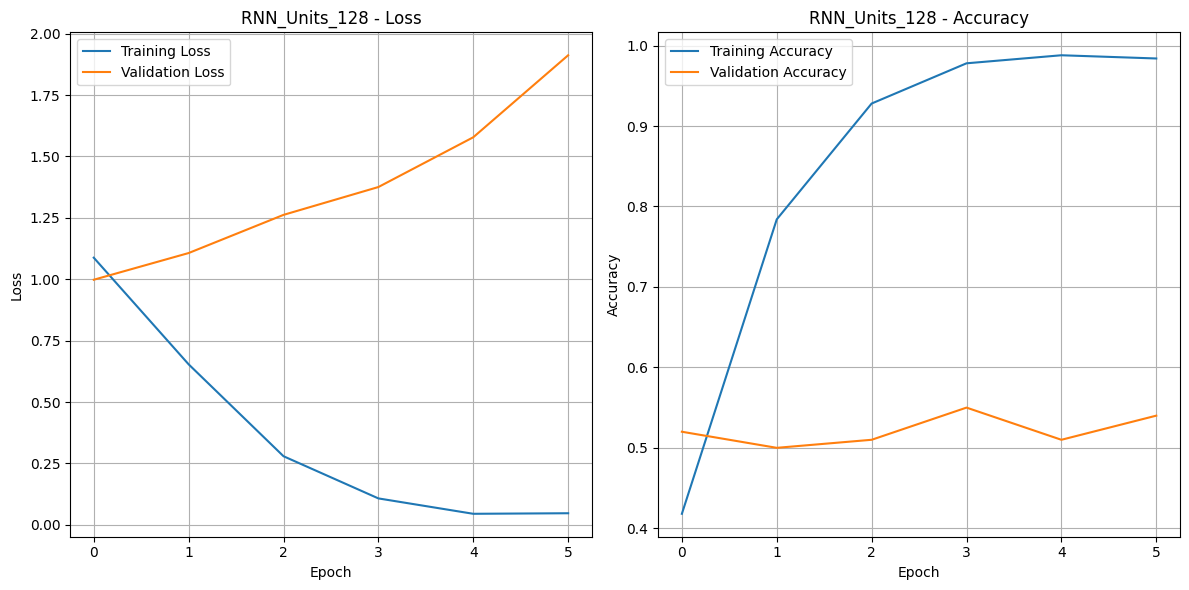

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Units_128_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Macro F1-score on Validation set: 0.5097
Macro F1-score on Test set: 0.5028

--- Summary: Pengaruh banyak cell RNN per layer ---
RNN_Units_32: Validation Macro F1 = 0.4312, Test Macro F1 = 0.4906
RNN_Units_64: Validation Macro F1 = 0.4981, Test Macro F1 = 0.4759
RNN_Units_128: Validation Macro F1 = 0.5097, Test Macro F1 = 0.5028


In [13]:
rnn_units_variations = [32, 64, 128]

results_units = {}

for units in rnn_units_variations:
    model_params = {
        'num_rnn_layers': 2,
        'rnn_units': units,
        'rnn_direction': 'unidirectional'
    }
    model_name = f"RNN_Units_{units}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_units[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh banyak cell RNN per layer ---")
for name, res in results_units.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Variation in RNN Layer Direction


--- Training Model: RNN_Direction_unidirectional ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,275 (774.51 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3413 - loss: 1.1414

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3441 - loss: 1.1384 - val_accuracy: 0.5300 - val_loss: 1.0312
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6821 - loss: 0.7871 - val_accuracy: 0.5300 - val_loss: 1.0398
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9248 - loss: 0.4308 - val_accuracy: 0.5000 - val_loss: 1.1712
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9784 - loss: 0.1706 - val_accuracy: 0.4900 - val_loss: 1.2431
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9862 - loss: 0.0697 - val_accuracy: 0.5000 - val_loss: 1.4466
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9964 - loss: 0.0335 - val_accuracy: 0.4700 - val_loss: 1.6102


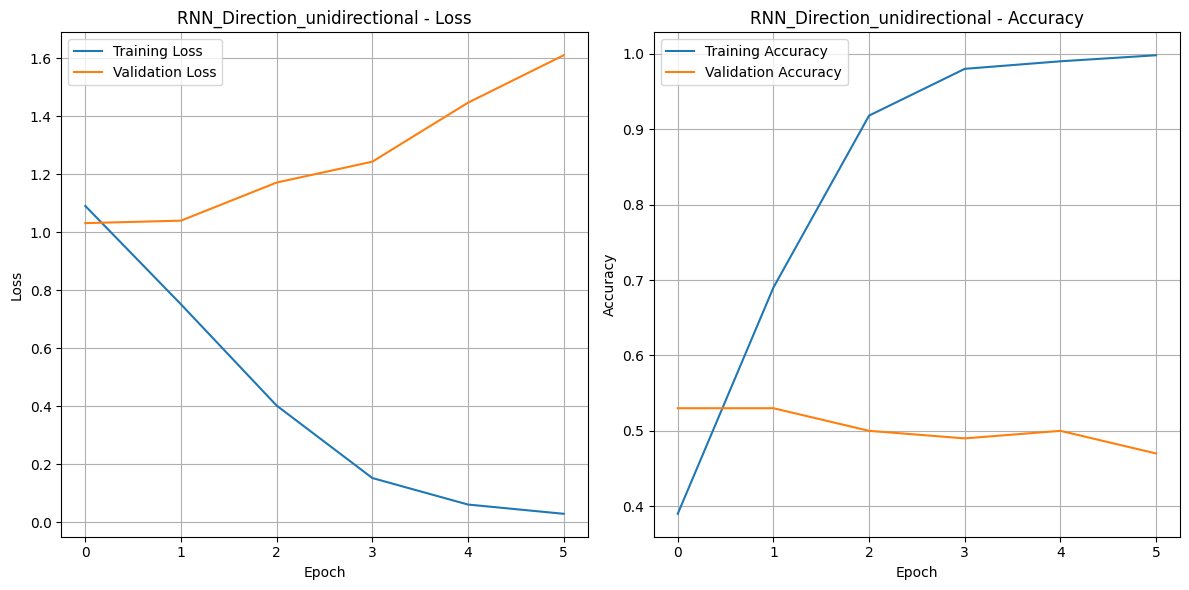

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Direction_unidirectional_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Macro F1-score on Validation set: 0.4649
Macro F1-score on Test set: 0.4642

--- Training Model: RNN_Direction_bidirectional ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,171 (871.76 KB)

 Trainable params: 223,171 (871.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3167 - loss: 1.1518

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3222 - loss: 1.1472 - val_accuracy: 0.4800 - val_loss: 1.0526
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6957 - loss: 0.7572

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6993 - loss: 0.7538 - val_accuracy: 0.5500 - val_loss: 0.9522
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9203 - loss: 0.3685 - val_accuracy: 0.5500 - val_loss: 1.0381
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9970 - loss: 0.1135 - val_accuracy: 0.5900 - val_loss: 1.1078
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0384 - val_accuracy: 0.5500 - val_loss: 1.2274
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0196 - val_accuracy: 0.5900 - val_loss: 1.2296
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.6000 - val_loss: 1.2486


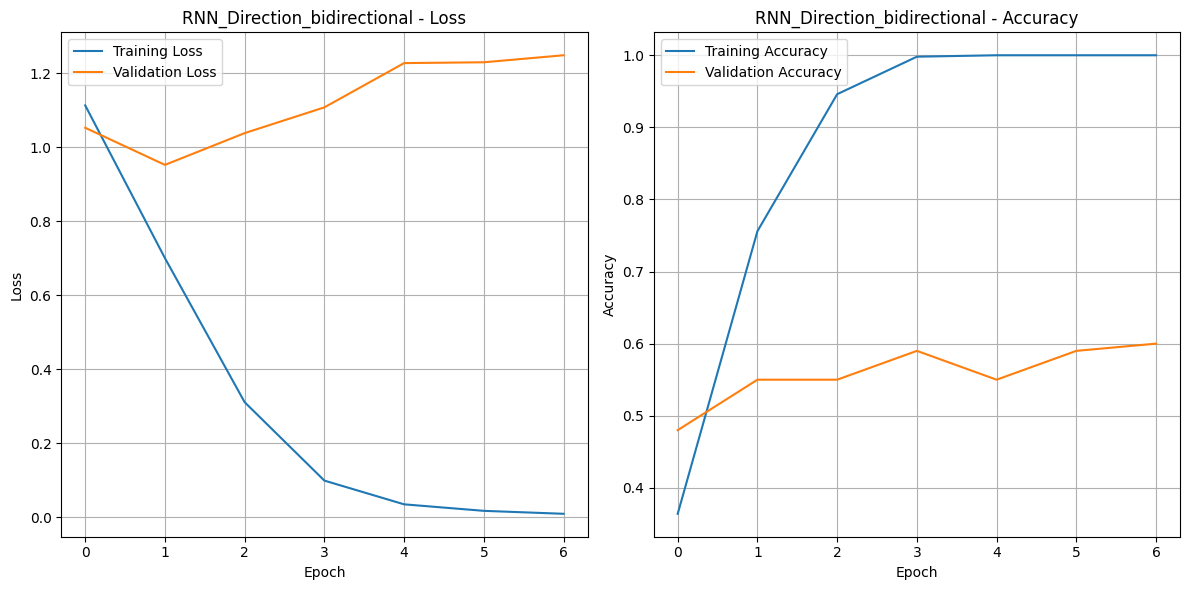

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Direction_bidirectional_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Macro F1-score on Validation set: 0.5864
Macro F1-score on Test set: 0.5604

--- Summary: Pengaruh jenis layer rnn berdasarkan arah ---
RNN_Direction_unidirectional: Validation Macro F1 = 0.4649, Test Macro F1 = 0.4642
RNN_Direction_bidirectional: Validation Macro F1 = 0.5864, Test Macro F1 = 0.5604


In [14]:
rnn_direction_variations = ['unidirectional', 'bidirectional']

results_direction = {}

for direction in rnn_direction_variations:
    model_params = {
        'num_rnn_layers': 2,
        'rnn_units': 64,
        'rnn_direction': direction
    }
    model_name = f"RNN_Direction_{direction}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_direction[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jenis layer rnn berdasarkan arah ---")
for name, res in results_direction.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Overall Analysis and Conclusions

In [15]:
# Helper function to print conclusions clearly
def print_conclusion(experiment_name, results_dict):
    print(f"\n--- {experiment_name} ---")
    best_val_f1 = -1
    best_model_name = ""
    for name, res in results_dict.items():
        print(f"{name}: Val Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")
        if res['val_macro_f1'] > best_val_f1:
            best_val_f1 = res['val_macro_f1']
            best_model_name = name
    print(f"Best performing model in this experiment (based on Validation F1): {best_model_name} (F1: {best_val_f1:.4f})")

print_conclusion("Pengaruh jumlah layer RNN", results_layer_count)
print_conclusion("Pengaruh banyak cell RNN per layer", results_units)
print_conclusion("Pengaruh jenis layer RNN berdasarkan arah", results_direction)


--- Pengaruh jumlah layer RNN ---
RNN_layers_1: Val Macro F1 = 0.4314, Test Macro F1 = 0.5119
RNN_layers_2: Val Macro F1 = 0.5542, Test Macro F1 = 0.5281
RNN_layers_3: Val Macro F1 = 0.5422, Test Macro F1 = 0.5314
Best performing model in this experiment (based on Validation F1): RNN_layers_2 (F1: 0.5542)

--- Pengaruh banyak cell RNN per layer ---
RNN_Units_32: Val Macro F1 = 0.4312, Test Macro F1 = 0.4906
RNN_Units_64: Val Macro F1 = 0.4981, Test Macro F1 = 0.4759
RNN_Units_128: Val Macro F1 = 0.5097, Test Macro F1 = 0.5028
Best performing model in this experiment (based on Validation F1): RNN_Units_128 (F1: 0.5097)

--- Pengaruh jenis layer RNN berdasarkan arah ---
RNN_Direction_unidirectional: Val Macro F1 = 0.4649, Test Macro F1 = 0.4642
RNN_Direction_bidirectional: Val Macro F1 = 0.5864, Test Macro F1 = 0.5604
Best performing model in this experiment (based on Validation F1): RNN_Direction_bidirectional (F1: 0.5864)


## Forward Pass Comparison

In [16]:
unidirection_to_load = f"{MODEL_SAVE_DIR}/RNN_Direction_unidirectional_best.h5"
bidirection_to_load = f"{MODEL_SAVE_DIR}/RNN_Direction_bidirectional_best.h5"

### Unidirectional Model

In [17]:
from sequential import Sequential
from layers.text_vectorization import TextVectorizationWrapper
from layers.embedding import Embedding
from layers.dense import Dense
from layers.dropout import Dropout
from layers.simple_rnn import SimpleRNN
from layers.bidirectional import Bidirectional

custom_unidirectional_rnn = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),
    SimpleRNN(units=64, return_sequences=True),
    Dropout(),
    SimpleRNN(units=64,return_sequences=False),
    Dropout(),
    Dense(3,activation="softmax")
])

In [18]:
custom_unidirectional_rnn.load_weights(unidirection_to_load)

HDF5 layer keys: ['dense_6', 'dropout_12', 'dropout_13', 'embedding_6', 'simple_rnn_12', 'simple_rnn_13', 'text_vectorization', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_6)
Loading 3 weight array(s) into layer 2 (type: SimpleRNN, key: simple_rnn_12)
Weight successfuly loaded
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_12)
Dropout has no trainable weights — skipping
Loading 3 weight array(s) into layer 4 (type: SimpleRNN, key: simple_rnn_13)
Weight successfuly loaded
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_13)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_6)


In [19]:
keras_model_unidirectional = tf.keras.models.load_model(unidirection_to_load)
keras_model_unidirectional.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,277 (774.52 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [20]:
text_vectorization_layer_loaded = None
for layer in keras_model_unidirectional.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [21]:
y_test_pred_probs = keras_model_unidirectional.predict(x_test)
print(y_test_pred_probs[:5])
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred_classes[:5])

evaluate_macro_f1(y_test, y_test_pred_classes, "Unidirectional Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.43934613 0.10444681 0.45620722]
 [0.35116112 0.3565196  0.29231933]
 [0.48506835 0.1468401  0.36809155]
 [0.41841215 0.09407207 0.4875157 ]
 [0.40095475 0.37423804 0.22480716]]
[2 1 0 2 0]
Macro F1-score on Unidirectional Keras Model Test set: 0.4192


0.4192240953652491

In [22]:
# 1. Perform prediction with your custom model
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs = custom_unidirectional_rnn.predict(x_test)
print(custom_model_pred_probs[:5])
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)
print(custom_model_pred_classes[:50])

# 2. Calculate F1 score for your custom model
# You'll need an evaluation function, similar to what you used for the Keras model
# (Assuming you have an 'evaluate_macro_f1' function)
evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
[[0.43934602 0.10444678 0.4562072 ]
 [0.35116115 0.35651959 0.29231927]
 [0.48506827 0.1468401  0.36809163]
 [0.41841211 0.09407209 0.4875158 ]
 [0.40095475 0.37423811 0.22480714]]
[2 1 0 2 0 2 0 0 2 2 0 2 0 1 0 2 0 2 2 2 2 2 2 0 0 2 2 2 2 2 2 0 2 2 0 0 2
 2 2 2 0 2 2 2 2 2 2 0 2 0]
Macro F1-score on Custom Model Test set: 0.4192


0.4192240953652491

### Bidirectional Model

In [23]:
custom_bidirectional_rnn = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero= True
    ),
    Bidirectional(SimpleRNN(units=64, return_sequences=True)),
    Dropout(),
    Bidirectional(SimpleRNN(units=64,return_sequences=False)),
    Dropout(),
    Dense(3,activation="softmax")
])

In [24]:
custom_bidirectional_rnn.load_weights(bidirection_to_load)

HDF5 layer keys: ['bidirectional', 'bidirectional_1', 'dense_7', 'dropout_14', 'dropout_15', 'embedding_7', 'text_vectorization', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_7)
Loading 6 weight array(s) into layer 2 (type: Bidirectional, key: bidirectional)
Weight successfuly loaded
Weight successfuly loaded
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_14)
Dropout has no trainable weights — skipping
Loading 6 weight array(s) into layer 4 (type: Bidirectional, key: bidirectional_1)
Weight successfuly loaded
Weight successfuly loaded
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_15)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_7)


In [25]:
keras_model_bidirectional = tf.keras.models.load_model(bidirection_to_load)
keras_model_bidirectional.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,173 (871.77 KB)

 Trainable params: 223,171 (871.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [26]:
text_vectorization_layer_loaded = None
for layer in keras_model_bidirectional.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [27]:
y_test_pred_probs = keras_model_bidirectional.predict(x_test)
print(y_test_pred_probs[:5])
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred_classes[:5])

evaluate_macro_f1(y_test, y_test_pred_classes, "Bidirectional Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
[[0.14551936 0.09304512 0.7614355 ]
 [0.43845704 0.3221727  0.23937014]
 [0.3554874  0.32197702 0.32253566]
 [0.18658915 0.0611734  0.75223744]
 [0.5806117  0.29364282 0.12574545]]
[2 0 0 2 0]
Macro F1-score on Bidirectional Keras Model Test set: 0.5254


0.5253546632034342

In [28]:
# 1. Perform prediction with your custom model
print("\n--- Predicting with Custom Bidirectional Sequential Model ---")
custom_model_pred_probs = custom_bidirectional_rnn.predict(x_test)
print(custom_model_pred_probs[:5])
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)
print(custom_model_pred_classes[:50])

# 2. Calculate F1 score for your custom model
# You'll need an evaluation function, similar to what you used for the Keras model
# (Assuming you have an 'evaluate_macro_f1' function)
evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Bidirectional Model Test")


--- Predicting with Custom Bidirectional Sequential Model ---
[[0.1455193  0.09304506 0.76143564]
 [0.43845713 0.32217275 0.23937013]
 [0.35548723 0.32197692 0.32253586]
 [0.18658937 0.06117344 0.7522372 ]
 [0.58061175 0.29364285 0.12574539]]
[2 0 0 2 0 2 0 1 2 2 1 2 0 0 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 1 2 2 0 0 2
 2 2 2 2 2 0 0 1 0 0 0 1 0]
Macro F1-score on Custom Bidirectional Model Test set: 0.5254


0.5253546632034342